# Analisi i predicció dels accidents de transit a Barcelona

## Predictor of the escaped car after a collision

In [0]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import folium
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import optimizers
import io


Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving 2016_accidents_vehicles_gu_bcn_.csv to 2016_accidents_vehicles_gu_bcn_.csv
Saving 2017_accidents_vehicles_gu_bcn_.csv to 2017_accidents_vehicles_gu_bcn_.csv
Saving 2018_accidents_vehicles_gu_bcn_.csv to 2018_accidents_vehicles_gu_bcn_.csv


In [0]:
from google.colab import files
uploaded_tipus_acc = files.upload()

Saving 2016_accidents_tipus_gu_bcn_.csv to 2016_accidents_tipus_gu_bcn_.csv
Saving 2017_accidents_tipus_gu_bcn_.csv to 2017_accidents_tipus_gu_bcn_.csv
Saving 2018_accidents_tipus_gu_bcn_.csv to 2018_accidents_tipus_gu_bcn_.csv


# Loadind cleaning type of accident

In [0]:
### Load datasets

accidents_tipus6 = pd.read_csv(io.BytesIO(uploaded_tipus_acc['2016_accidents_tipus_gu_bcn_.csv']))
accidents_tipus7 = pd.read_csv(io.BytesIO(uploaded_tipus_acc['2017_accidents_tipus_gu_bcn_.csv']))
accidents_tipus8 = pd.read_csv(io.BytesIO(uploaded_tipus_acc['2018_accidents_tipus_gu_bcn_.csv']))

accidents_vehicles_tipus = pd.concat([accidents_tipus6, accidents_tipus7, accidents_tipus8],ignore_index=True)

select_atributs=['Numero_expedient','Descripcio_tipus_accident']
accidents_vehicles_tipus = accidents_vehicles_tipus[select_atributs]
accidents_vehicles_tipus.rename(columns={'Numero_expedient':'Codi_expedient'}, inplace=True)


accidents_vehicles_tipus


,Codi_expedient,Descripcio_tipus_accident
0,2016S002575,Abast
1,2016S001146,Col.lisió lateral
2,2016S009619,Atropellament
3,2016S003881,Xoc contra element estàtic
4,2016S004162,Xoc contra element estàtic
5,2016S009951,Atropellament
6,2016S004619,Abast
7,2016S009702,Caiguda (dues rodes)
8,2016S003529,Col.lisió fronto-lateral
9,2016S008654,Col.lisió lateral


# Cleaning of the car accidents dataset

In [0]:
### Load datasets

accidents_vehicles2016 = pd.read_csv(io.BytesIO(uploaded['2016_accidents_vehicles_gu_bcn_.csv']))
accidents_vehicles2017 = pd.read_csv(io.BytesIO(uploaded['2017_accidents_vehicles_gu_bcn_.csv']))
accidents_vehicles2018 = pd.read_csv(io.BytesIO(uploaded['2018_accidents_vehicles_gu_bcn_.csv']))

accidents_vehicles2018.drop(['Descripcio_torn'], axis=1, inplace=True)

print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2016.shape[0], accidents_vehicles2016.shape[1]))
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2017.shape[0], accidents_vehicles2017.shape[1]))
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2018.shape[0], accidents_vehicles2018.shape[1]))

### Renaming some columns for the join.
accidents_vehicles2016.rename(columns={' Longitud':'Longitud'}, inplace=True)
accidents_vehicles2016.rename(columns={' Latitud':'Latitud'}, inplace=True)

### Concat the 3 datasets together.
accidents_vehicles = pd.concat([accidents_vehicles2016, accidents_vehicles2017, accidents_vehicles2018],ignore_index=True)
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles.shape[0], accidents_vehicles.shape[1]))

num_columns = len(accidents_vehicles.columns)
pd.set_option("display.max_columns", num_columns)
accidents_vehicles

DataSet Persones - Nombre instances: 19410, number of Training attributes: 27
DataSet Persones - Nombre instances: 19795, number of Training attributes: 27
DataSet Persones - Nombre instances: 19079, number of Training attributes: 27
DataSet Persones - Nombre instances: 58284, number of Training attributes: 28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Antiguitat_carnet,Codi_barri,Codi_carrer,Codi_districte,Codi_expedient,Coordenada_UTM_X,Coordenada_UTM_Y,Descripcio_carnet,Descripcio_causa_vianant,Descripcio_color,Descripcio_dia_setmana,Descripcio_marca,Descripcio_model,Descripcio_tipus_dia,Descripcio_tipus_vehicle,Dia_mes,Dia_setmana,Hora_dia,Latitud,Longitud,Mes_any,NK_Any,Nom_barri,Nom_carrer,Nom_districte,Nom_mes,Num_postal,Num_postal_caption
0,11,22,700053,5,2016S004659,"423606,83","4586843,04",C,No és causa del vianant,Blanc,Dimecres,RENAULT,370,Laboral,"Camión > 3,5 Tm",15,Dc,11,41.4277,2.08459,6,2016,"Vallvidrera, el Tibidabo i les Planes",Mig de Can Balasch,Sarrià-Sant Gervasi,Juny,NaN,0017 0017
1,12,22,202050,5,2016S008630,"424249,09","4586527,04",B,No és causa del vianant,Blanc,Dijous,AUDI,A6,Laboral,Turismo,10,Dj,19,41.4249,2.09232,11,2016,"Vallvidrera, el Tibidabo i les Planes",Mas Guimbau,Sarrià-Sant Gervasi,Novembre,NaN,0001B0001B
2,66,22,202050,5,2016S008630,"424249,09","4586527,04",B,No és causa del vianant,Altres,Dijous,LEXUS,LS 400,Laboral,Turismo,10,Dj,19,41.4249,2.09232,11,2016,"Vallvidrera, el Tibidabo i les Planes",Mas Guimbau,Sarrià-Sant Gervasi,Novembre,NaN,0001B0001B
3,9,22,700059,5,2016S009877,"424262,4","4586543,35",A,No és causa del vianant,Negre,Dimecres,HONDA,Desconegut,Laboral,Motocicleta,21,Dc,18,41.425,2.09248,12,2016,"Vallvidrera, el Tibidabo i les Planes",Vallvidrera a les Planes,Sarrià-Sant Gervasi,Desembre,NaN,0067 0069
4,21,22,700059,5,2016S009877,"424262,4","4586543,35",B,No és causa del vianant,Blanc,Dimecres,SMART,FORTWO,Laboral,Turismo,21,Dc,18,41.425,2.09248,12,2016,"Vallvidrera, el Tibidabo i les Planes",Vallvidrera a les Planes,Sarrià-Sant Gervasi,Desembre,NaN,0067 0069
5,14,22,221928,5,2016S002188,"424412,65","4585743,93",C,No és causa del vianant,Blanc,Dissabte,IVECO FIAT,STRALIS,Laboral,"Camión <= 3,5 Tm",19,Ds,7,41.4178,2.09437,3,2016,"Vallvidrera, el Tibidabo i les Planes",Rovelló,Sarrià-Sant Gervasi,Març,NaN,0020 0020
6,6,22,221928,5,2016S002188,"424412,65","4585743,93",A2,No és causa del vianant,Negre,Dissabte,SUZUKI,DR Z,Laboral,Motocicleta,19,Ds,7,41.4178,2.09437,3,2016,"Vallvidrera, el Tibidabo i les Planes",Rovelló,Sarrià-Sant Gervasi,Març,NaN,0020 0020
7,11,22,700059,5,2016S004036,"424610,52","4585995,05",A,No és causa del vianant,Blau,Dijous,HONDA,SH 300,Laboral,Motocicleta,26,Dj,7,41.4201,2.09671,5,2016,"Vallvidrera, el Tibidabo i les Planes",Vallvidrera a les Planes,Sarrià-Sant Gervasi,Maig,NaN,0010 0018
8,18,22,700059,5,2016S004036,"424610,52","4585995,05",B,No és causa del vianant,Blanc,Dijous,RENAULT,CLIO,Laboral,Turismo,26,Dj,7,41.4201,2.09671,5,2016,"Vallvidrera, el Tibidabo i les Planes",Vallvidrera a les Planes,Sarrià-Sant Gervasi,Maig,NaN,0010 0018
9,44,22,700059,5,2016S007973,"424650,38","4585930,55",B,Creuar per fora pas de vianants,Blau,Dijous,HONDA,ACCORD,Laboral,Turismo,20,Dj,7,41.4196,2.0972,10,2016,"Vallvidrera, el Tibidabo i les Planes",Vallvidrera a les Planes,Sarrià-Sant Gervasi,Octubre,NaN,520000


In [0]:
### Merge both datasets.
accidents_vehicles = pd.merge(accidents_vehicles, accidents_vehicles_tipus, on = ['Codi_expedient'], how='inner')
accidents_vehicles = accidents_vehicles[accidents_vehicles['Descripcio_tipus_accident']!='Desconegut']


In [0]:
### Clean the negative data that identifies errors or missing data in the samples.
accidents_vehicles = accidents_vehicles[accidents_vehicles['Codi_districte'] > 0] #Eliminem els districtes -1
accidents_vehicles = accidents_vehicles[accidents_vehicles['Codi_carrer'] > 0] #Eliminem els districtes -1

### Select the attributes of interest.
atributs_selecionats = ['Codi_barri','Descripcio_tipus_accident','Codi_carrer','Codi_districte','Descripcio_color','Descripcio_marca', 'Dia_setmana','Descripcio_causa_vianant',
                        'Descripcio_model','Descripcio_tipus_dia','Descripcio_dia_setmana','Descripcio_tipus_vehicle','Antiguitat_carnet','Dia_mes',
                        'Hora_dia','Mes_any','NK_Any','Latitud','Longitud']
accidents_vehicles = accidents_vehicles[atributs_selecionats]

In [0]:
### Manualy fix the different names the police has given to the same brand.
accidents_vehicles = accidents_vehicles.replace({'A.U.D.I.': 'AUDI'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'A U D I': 'AUDI'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MERCEDES-BENZ': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MECEDES': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MERCEDES B': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'B.M.W.': 'BMW'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'B M W': 'BMW'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MICROCAR': 'SMART'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'JAGUAR LAND ROV': 'LAND ROVER'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'Turismo': 'Turisme'}, regex=True)

### We will just predict Cars for now.
accidents_vehicles = accidents_vehicles[accidents_vehicles['Descripcio_tipus_vehicle']=='Turisme']

### Check if there is a duplicated brand.
accidents_vehicles['Descripcio_model'].unique()


array(['A6', 'LS 400', 'FORTWO', ..., 'COMFORT 5P', 'R. LAGUNA',
       'GRAND VOYA'], dtype=object)

In [0]:
### Getting rid of samples with unknown model description 
accidents_vehicles2_not = accidents_vehicles[accidents_vehicles['Descripcio_model']=='Desconegut']
accidents_vehicles2_not = accidents_vehicles[accidents_vehicles['Descripcio_model']=='ES DESCONEIX']

accidents_vehicles2 = accidents_vehicles[accidents_vehicles['Descripcio_model']!='Desconegut']
accidents_vehicles3 = accidents_vehicles2[accidents_vehicles2['Descripcio_model']!='ES DESCONEIX']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Antiguitat_carnet']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_color']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_marca']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_model']!=' ']
 
accidents_vehicles3['Descripcio_marca'].unique()

array(['AUDI', 'LEXUS', 'SMART', 'RENAULT', 'HONDA', 'SEAT', 'OPEL',
       'VOLVO', 'TOYOTA', 'PEUGEOT', 'MERCEDES', 'NISSAN', 'FIAT',
       'HYUNDAI', 'VOLKSWAGEN', 'CITROEN', 'FORD', 'MITSUBISHI',
       'LAND ROVER', 'KIA', 'SAAB', 'ALFA ROMEO', 'MINI', 'MAZDA',
       'DACIA', 'LANCIA', 'BMW', 'CHEVROLET', 'JAGUAR', 'TATA', 'DAEWOO',
       'SUZUKI', 'SKODA', 'CHRYSLER', 'SUBARU', 'JEEP', 'SSANGYONG', 'MG',
       'PORSCHE', 'ROVER', 'MAN', 'DODGE', 'MASERATI', 'BYD', 'FERRARI',
       'MAHINDRA', 'DAIMLER', 'INFINITI', 'PIAGGIO', 'YAMAHA', 'HUMMER',
       'SYM', 'IVECO FIAT', 'ASTON MARTIN', 'CADILLAC', 'KYMCO',
       'ROLLS-ROYCE', 'IRISBUS', 'LEONART', 'S.Y.M', 'APRILIA',
       'IVECO BUS', 'GALLOPER'], dtype=object)

In [0]:
### Select just the 200 most common car models involved in accidents in Barcelona. 
select_vehicles = accidents_vehicles3["Descripcio_model"].value_counts().iloc[:200].index
accidents_vehicles5 = accidents_vehicles3[accidents_vehicles3["Descripcio_model"].isin(select_vehicles)]

### Fix some issues with car models
accidents_vehicles5 = accidents_vehicles5.replace({'C-MAX': 'C MAX'}, regex=True)
accidents_vehicles5 = accidents_vehicles5.replace({'A-3 2.0': 'A3'}, regex=True)
accidents_vehicles5 = accidents_vehicles5.replace({'MINI COOPER': 'COOPER'}, regex=True)

### Add a point at the begining of the car models to know its the car model an not a brand.
accidents_vehicles5['Descripcio_model'] = '.' + accidents_vehicles5['Descripcio_model'].astype(str)
accidents_vehicles5['Descripcio_model'].unique()

array(['.A6', '.FORTWO', '.CLIO', '.ACCORD', '.Altea', '.MERIVA',
       '.IBIZA', '.S40', '.YARIS', '.207', '.Q7', '.508', '.KANGOO',
       '.307', '.C 220', '.ALMERA', '.MEGANE', '.ALHAMBRA', '.306',
       '.500', '.ATOS', '.CORDOBA', '.SCENIC', '.TIGUAN', '.C4', '.C2',
       '.FIESTA', '.206', '.AYGO', '.C3', '.CIVIC', '.SAXO', '.CLS',
       '.RANGE ROVER', '.XC 60', '.LEON', '.CARENS', '.GOLF', '.PASSAT',
       '.QASHQAI', '.TOLEDO', '.A1', '.FOCUS', '.XSARA', '.I 10',
       '.C 180', '.ACCENT', '.208', '.147', '.ONE', '.POLO', '.RAV - 4',
       '.PRIMERA', '.CORSA', '.A3', '.KUGA', '.MAZDA 3', '.MAZDA 6',
       '.SANDERO', '.SHARAN', '.X5', '.KA', '.A4', '.ASTRA', '.XC 90',
       '.TOURAN', '.Santa Fe', '.A 180', '.S-MAX', '.Getz', '.525',
       '.I 30', '.MII', '.CLA 220', '.C MAX', '.MOKKA', '.E 220',
       '.CARNIVAL', '.DISCOVERY', '.JAZZ', '.308', '.SIROCCO', '.I 20',
       '.INSIGNIA', '.PUNTO', '.MONDEO', '.SPORTAGE', '.ZAFIRA', '.116',
       '.CRV', '.SWIFT', 

In [0]:
### Group by per car brand and model. 
accidents_vehicles_grpby = accidents_vehicles5.groupby(['Descripcio_marca', 'Descripcio_model'])
accidents_vehicles_grpby = accidents_vehicles_grpby.first() 
accidents_vehicles_grpby

Codi_barri   Descripcio_tipus_accident  \
Descripcio_marca Descripcio_model                                           
ALFA ROMEO       .147                      21    Col.lisió fronto-lateral   
                 .GIULIETTA                23           Col.lisió lateral   
AUDI             .A1                       20                      Altres   
                 .A3                       21           Col.lisió lateral   
                 .A4                       21                       Abast   
                 .A5                       21    Col.lisió fronto-lateral   
                 .A6                       22           Col.lisió lateral   
                 .COUPE                    12  Xoc contra element estàtic   
                 .Q3                       19                       Abast   
                 .Q5                       23               Atropellament   
                 .Q7                       22           Col.lisió frontal   
BMW              .116                      23  Xoc contra element estàtic   
                 .118                      23  Xoc contra element estàtic   
                 .118 D                    11    Caiguda interior vehicle   
                 .120D                     20           Col.lisió lateral   
                 .218d                     21              Abast multiple   
                 .220                      12              Abast multiple   
                 .316                      19               Atropellament   
                 .318                       9    Col.lisió fronto-lateral   
                 .320                      19    Col.lisió fronto-lateral   
                 .320D                     25                       Abast   
                 .330                       7           Col.lisió lateral   
                 .520                      12    Col.lisió fronto-lateral   
                 .525                      20                       Abast   
                 .530                      17           Col.lisió lateral   
                 .SERIE 1                  18                       Abast   
                 .SERIE 3                  20           Col.lisió lateral   
                 .X1                       23           Col.lisió lateral   
                 .X3                       23              Abast multiple   
                 .X5                       21                       Abast   
...                                       ...                         ...   
SKODA            .OCTAVIA                  20           Col.lisió frontal   
                 .Superb                   17                      Altres   
SMART            .FORFOUR                  19                       Abast   
                 .FORTWO                   22    Col.lisió fronto-lateral   
                 .SMART                    23               Atropellament   
SUBARU           .FORESTER                 12           Col.lisió lateral   
SUZUKI           .SWIFT                    21    Col.lisió fronto-lateral   
TOYOTA           .AURIS                    21           Col.lisió lateral   
                 .AVENSIS                  23                       Abast   
                 .AYGO                     20              Abast multiple   
                 .COROLLA                  21    Col.lisió fronto-lateral   
                 .LAND CRUISER             20                      Altres   
                 .PRIUS                    23                       Abast   
                 .RAV - 4                  21           Col.lisió lateral   
                 .VERSO                    12              Abast multiple   
                 .YARIS                    21              Abast multiple   
VOLKSWAGEN       .GOLF                     20                       Abast   
                 .PASSAT                   20                       Abast   
                 .POLO                     21                       Abast   
                 .SHARAN       

In [0]:
from google.colab import files
uploaded2 = files.upload()

Saving accidents_vehicles_portes_tipus.xlsx to accidents_vehicles_portes_tipus.xlsx


In [0]:
### Load and merge it with the previous dataset.

models_i_portes = pd.read_excel(io.BytesIO(uploaded2['accidents_vehicles_portes_tipus.xlsx']))
accidents_vehicles6 = pd.merge(accidents_vehicles5, models_i_portes, on = ['Descripcio_marca','Descripcio_model'], how='inner')
accidents_vehicles6 = accidents_vehicles6[accidents_vehicles6['Num_portes_laterals']!=-1]
accidents_vehicles6


,Codi_barri,Descripcio_tipus_accident,Codi_carrer,Codi_districte,Descripcio_color,Descripcio_marca,Dia_setmana,Descripcio_causa_vianant,Descripcio_model,Descripcio_tipus_dia,Descripcio_dia_setmana,Descripcio_tipus_vehicle,Antiguitat_carnet,Dia_mes,Hora_dia,Mes_any,NK_Any,Latitud,Longitud,Num_portes_laterals,Tipus_cotxe
0,22,Col.lisió lateral,202050,5,Blanc,AUDI,Dj,No és causa del vianant,.A6,Laboral,Dijous,Turisme,12,10,19,11,2016,41.4249,2.09232,4,sedan
1,20,Abast,700931,4,Gris,AUDI,Dv,No és causa del vianant,.A6,Laboral,Divendres,Turisme,20,20,10,5,2016,41.3812,2.11892,4,sedan
2,20,Col.lisió lateral,700931,4,Gris,AUDI,Dv,No és causa del vianant,.A6,Laboral,Divendres,Turisme,20,20,10,5,2016,41.3812,2.11892,4,sedan
3,16,Col.lisió fronto-lateral,701377,3,Negre,AUDI,Dc,No és causa del vianant,.A6,Laboral,Dimecres,Turisme,42,21,12,9,2016,41.3657,2.13454,4,sedan
4,19,Col.lisió fronto-lateral,320704,4,Gris,AUDI,Ds,No és causa del vianant,.A6,Laboral,Dissabte,Turisme,6,18,3,6,2016,41.3905,2.14244,4,sedan
5,12,Abast,701266,3,Negre,AUDI,Dl,No és causa del vianant,.A6,Laboral,Dilluns,Turisme,19,11,12,7,2016,41.3495,2.14683,4,sedan
6,8,Col.lisió lateral,144601,2,Gris,AUDI,Dj,No és causa del vianant,.A6,Laboral,Dijous,Turisme,0,24,17,3,2016,41.3933,2.1479,4,sedan
7,8,Abast multiple,245802,2,Gris,AUDI,Dl,No és causa del vianant,.A6,Laboral,Dilluns,Turisme,17,4,11,1,2016,41.3921,2.15096,4,sedan
8,9,Col.lisió fronto-lateral,361406,2,Gris,AUDI,Dv,No és causa del vianant,.A6,Laboral,Divendres,Turisme,46,21,14,10,2016,41.3806,2.15588,4,sedan
9,8,Caiguda (dues rodes),32700,2,Gris,AUDI,Dm,No és causa del vianant,.A6,Laboral,Dimarts,Turisme,49,25,12,10,2016,41.3934,2.15702,4,sedan


### Ploting the number of the  most common car models.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


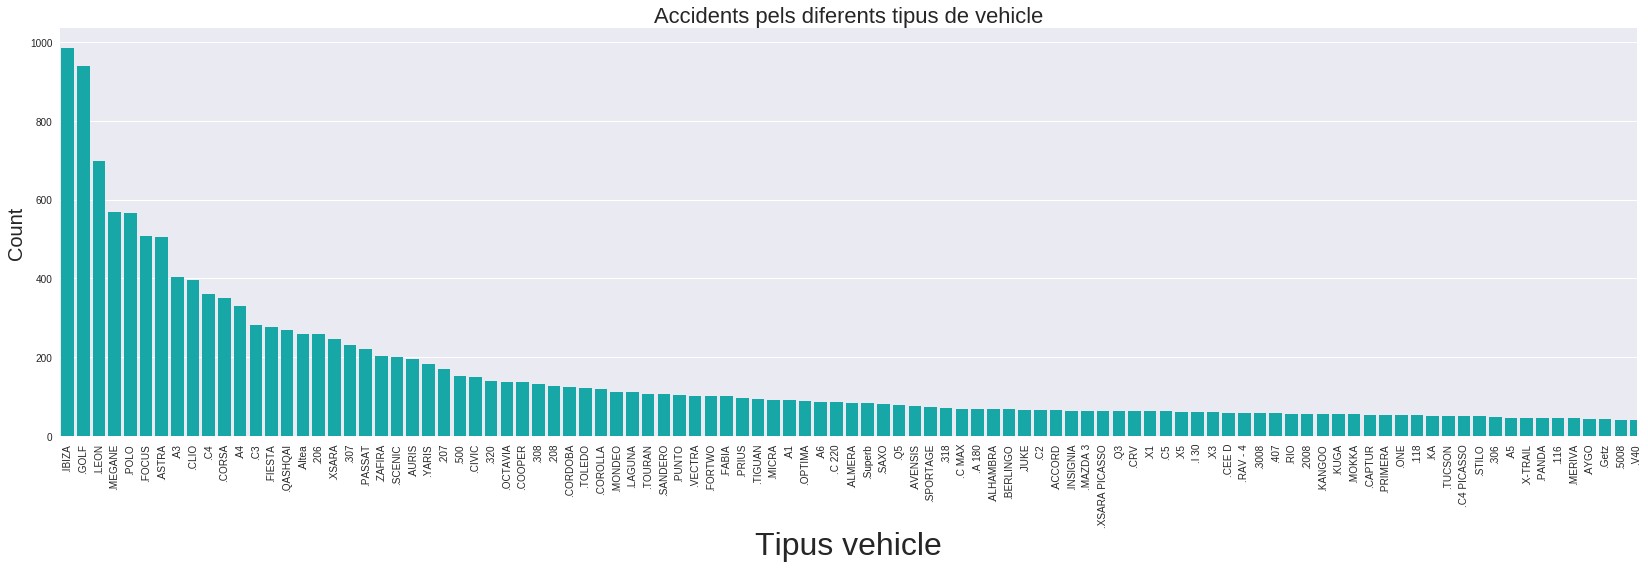

In [0]:
fig, ax = plt.subplots(figsize=(23,8))
ax = sns.countplot(x=accidents_vehicles6["Descripcio_model"], 
                   ax=ax,
                   order = accidents_vehicles6["Descripcio_model"].value_counts().index, color='c' )

plt.xticks(rotation=90)
plt.xlabel('Tipus vehicle', fontsize=32)
plt.ylabel('Count', fontsize=20)
plt.title('Accidents pels diferents tipus de vehicle', fontsize=22)
ax.set_xlim( right=100)
plt.tight_layout()
plt.show()

### Construct the baseline based on the most common car model for each brand.

In [0]:
accuracy = 0
for brand in accidents_vehicles6['Descripcio_marca'].unique():
    accidents_vehicles7 = accidents_vehicles6[accidents_vehicles6['Descripcio_marca']==brand]
    num_cars= len(accidents_vehicles7)
    print('- - -',brand,'- - -')
    print('Nombre de models de la marca en la sel.lecció: {}'.format(accidents_vehicles7['Descripcio_model'].unique()))
    print('Nombre d\'accidents de cotxes de la marca: {}'.format(num_cars))
    mode = accidents_vehicles7["Descripcio_model"].value_counts().max()
    mode_model = accidents_vehicles7["Descripcio_model"].max()
    relat_freq = mode/num_cars
    print('Percentatge del seu cotxe amb més accidents: {:.2f}% amb {} cotxes és amb el model {}.\n'.format(relat_freq*100, mode,mode_model))
    accuracy = accuracy + relat_freq*num_cars
    
print('### Accuracy d\'agafar la subclasse més comuna és: {:.5f} ### '.format(accuracy/len(accidents_vehicles5)))


- - - AUDI - - -
Nombre de models de la marca en la sel.lecció: ['.A6' '.Q7' '.A1' '.A3' '.A4' '.A5' '.Q5' '.Q3' '.COUPE']
Nombre d'accidents de cotxes de la marca: 1131
Percentatge del seu cotxe amb més accidents: 35.63% amb 403 cotxes és amb el model .Q7.

- - - SMART - - -
Nombre de models de la marca en la sel.lecció: ['.FORTWO' '.SMART' '.FORFOUR']
Nombre d'accidents de cotxes de la marca: 164
Percentatge del seu cotxe amb més accidents: 62.80% amb 103 cotxes és amb el model .SMART.

- - - RENAULT - - -
Nombre de models de la marca en la sel.lecció: ['.CLIO' '.KANGOO' '.MEGANE' '.SCENIC' '.LAGUNA' '.Modus' '.ESPACE'
 '.CAPTUR' '.TWINGO']
Nombre d'accidents de cotxes de la marca: 1485
Percentatge del seu cotxe amb més accidents: 38.25% amb 568 cotxes és amb el model .TWINGO.

- - - HONDA - - -
Nombre de models de la marca en la sel.lecció: ['.ACCORD' '.CIVIC' '.JAZZ' '.CRV']
Nombre d'accidents de cotxes de la marca: 311
Percentatge del seu cotxe amb més accidents: 47.91% amb 149 co

In [0]:
### One Hot Encoding to the non-numerical variables.
columns = ['Descripcio_color','Descripcio_marca','Descripcio_tipus_vehicle', 'NK_Any', 'Descripcio_tipus_accident',
          'Num_portes_laterals', 'Tipus_cotxe', 'Descripcio_dia_setmana','Descripcio_tipus_dia','Descripcio_causa_vianant']
for column in columns:
    accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6[column])], axis=1)

accidents_vehicles7 = accidents_vehicles6.copy()


In [0]:
# from google.colab import files
# accidents_vehicles7.to_csv('14-4_accidents_vehicles7.csv')
# files.download('14-4_accidents_vehicles7.csv')

In [0]:
# Labels are the values we want to predict
labels_y = pd.get_dummies(accidents_vehicles7['Descripcio_model'] ) 

# Remove the labels from the features
# axis 1 refers to the columns
features_X = accidents_vehicles7.drop(columns = ['Descripcio_color', 'Descripcio_marca', 
                                     'Descripcio_model','Descripcio_tipus_dia', 'NK_Any',
                                     'Descripcio_dia_setmana','Descripcio_tipus_vehicle',
                                     'Num_portes_laterals','Tipus_cotxe','Dia_setmana',
                                     'Descripcio_causa_vianant','Descripcio_tipus_accident'], axis = 1)

num_columns = len(features_X.columns)
pd.set_option("display.max_columns", num_columns)

features_X

,Codi_barri,Codi_carrer,Codi_districte,Antiguitat_carnet,Dia_mes,Hora_dia,Mes_any,Latitud,Longitud,Altres,Beige,Blanc,Blau,Daurat,Gris,Groc,Marró,Negre,Negre/Groc,Platejat,Rosa,Taronja,Verd,Vermell,Violeta,granate,ALFA ROMEO,AUDI,BMW,CHEVROLET,CHRYSLER,CITROEN,DACIA,DAEWOO,FIAT,FORD,HONDA,HYUNDAI,KIA,LANCIA,LAND ROVER,LEXUS,MAZDA,MERCEDES,MINI,MITSUBISHI,NISSAN,OPEL,PEUGEOT,RENAULT,ROVER,SAAB,SEAT,SKODA,SMART,SUBARU,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO,Turisme,2016,2017,2018,Abast,Abast multiple,Altres,Atropellament,Bolcada (més de dues rodes),Caiguda (dues rodes),Caiguda interior vehicle,Col.lisió frontal,Col.lisió fronto-lateral,Col.lisió lateral,Encalç,Resta sortides de via,Sortida de via amb bolcada,Sortida de via amb xoc o col.lisió,Xoc contra element estàtic,2,3,4,4x4/SUV,antic/classic,compact,esportiu,familiar,furgoneta,micro,sedan,Dijous,Dilluns,Dimarts,Dimecres,Dissabte,Diumenge,Divendres,Laboral,Altres,Creuar per fora pas de vianants,Desobeir altres senyals,Desobeir el senyal del semàfor,No és causa del vianant,Transitar a peu per la calçada
0,22,202050,5,12,10,19,11,41.4249,2.09232,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,700931,4,20,20,10,5,41.3812,2.11892,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,20,700931,4,20,20,10,5,41.3812,2.11892,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
3,16,701377,3,42,21,12,9,41.3657,2.13454,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,19,320704,4,6,18,3,6,41.3905,2.14244,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
5,12,701266,3,19,11,12,7,41.3495,2.14683,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
6,8,144601,2,0,24,17,3,41.3933,2.1479,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,8,245802,2,17,4,11,1,41.3921,2.15096,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
8,9,361406,2,46,21,14,10,41.3806,2.15588,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
9,8,32700,2,49,25,12,10,41.3934,2.15702,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split

### Split with 70 percent of the data for the training and 30 fer the testing.
Xtrain, Xtest, ytrain, ytest = train_test_split(features_X, 
                                                labels_y, 
                                                train_size=0.75, 
                                                random_state = 0
                                               )
 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
# Feature Scaling and normalisation of the data.
sc = StandardScaler()  
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)  
Xtest = sc.transform(Xtest) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [0]:
# get shapes
N, D = Xtrain.shape
K = len(set(ytrain))
print('D:', D, '\nK:',K)

D: 104 
K: 194


In [0]:
# The model will be a sequence of layers
model = Sequential()

model.add(Dense(units=64, input_dim=D))
# model.add(BatchNormalization())
model.add(Activation('tanh'))
# model.add(Dropout(0.2))

model.add(Dense(units=128)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=265)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1024)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1024)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=128)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=64)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=K))
model.add(BatchNormalization())
model.add(Activation('softmax'))

from keras.optimizers import SGD
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss = "categorical_crossentropy", optimizer = sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                6720      
_________________________________________________________________
activation_33 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
activation_34 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 265)               34185     
__________

In [0]:
# Fit the model and run it.
fited_model = model.fit(Xtrain, ytrain, 
                        validation_data=(Xtest, ytest), 
                        epochs=250, 
                        batch_size=2000, 
                       )

Train on 13612 samples, validate on 4538 samples
Epoch 1/250
13612/13612 [==============================] - 17s 1ms/step - loss: 5.6876 - acc: 0.0078 - val_loss: 4.8908 - val_acc: 0.0820
Epoch 2/250
13612/13612 [==============================] - 14s 993us/step - loss: 5.3345 - acc: 0.0164 - val_loss: 4.2293 - val_acc: 0.2252
Epoch 3/250
13612/13612 [==============================] - 14s 1ms/step - loss: 4.9353 - acc: 0.0403 - val_loss: 3.8830 - val_acc: 0.2922
Epoch 4/250
13612/13612 [==============================] - 14s 1ms/step - loss: 4.5977 - acc: 0.0810 - val_loss: 3.5842 - val_acc: 0.3239
Epoch 5/250
13612/13612 [==============================] - 14s 1ms/step - loss: 4.3099 - acc: 0.1445 - val_loss: 3.2907 - val_acc: 0.3565
Epoch 6/250
13612/13612 [==============================] - 14s 1ms/step - loss: 4.0450 - acc: 0.2118 - val_loss: 3.0163 - val_acc: 0.3876
Epoch 7/250
13612/13612 [==============================] - 14s 1ms/step - loss: 3.7869 - acc: 0.2699 - val_loss: 2.7823 -

## Analisis of the results

In [0]:
### Check the accuracy and the loss of the training set.
loss, accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))
print('')
### Also check for the testing set.
loss, accuracy = model.evaluate(Xtest, ytest, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.649420
Loss: 0.801003

Accuracy: 0.632401
Loss: 0.830677


In [0]:
### Classification report.
from sklearn.metrics import classification_report
print(classification_report(ytest,model.predict(Xtest).round()))
# y_pred = model.predict(Xtest)
# confusion_matrix(ytest, y_pred.round())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        11
           6       0.61      1.00      0.76        11
           7       0.00      0.00      0.00        10
           8       0.33      0.02      0.03        59
           9       0.00      0.00      0.00        43
          10       0.45      0.24      0.31        21
          11       1.00      1.00      1.00         7
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        11
          14       1.00      0.92      0.96        13
          15       0.00      0.00      0.00        61
          16       0.43      1.00      0.60        27
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
# from mlxtend.evaluate import confusion_matrix

# y_target = ytest
# y_predicted = model.predict(Xtest).round()

# cm = confusion_matrix(y_target=y_target, 
#                       y_predicted=y_predicted, 
#                       binary=False)
# cm

## Plot the log loss and the accuracy with the sucessive epochs

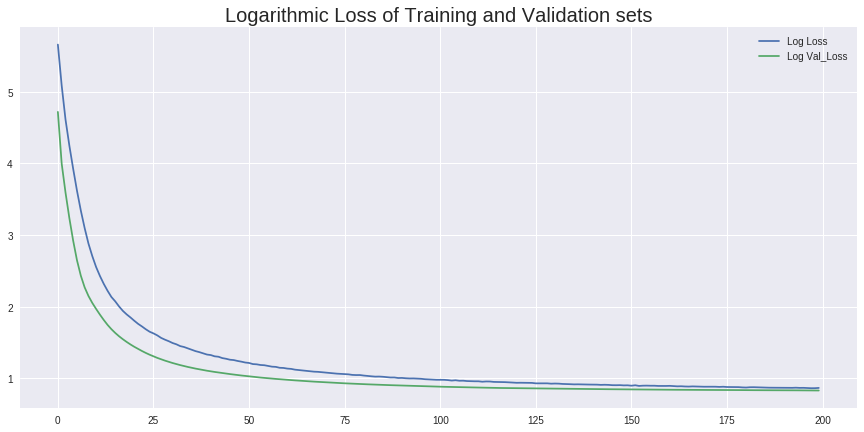

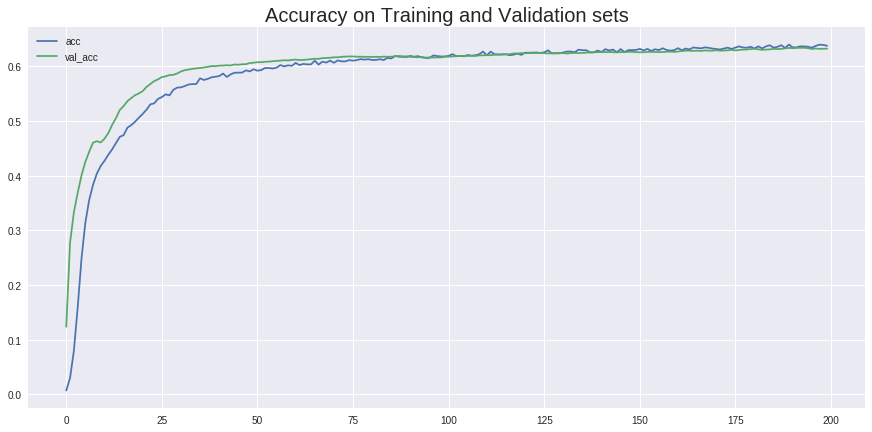

In [0]:
# plot some data
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['loss'], label='Log Loss')
plt.plot(fited_model.history['val_loss'], label='Log Val_Loss')
plt.title('Logarithmic Loss of Training and Validation sets', fontsize=20)

plt.legend()
plt.show()

fig = plt.figure(figsize=(15,7))
plt.plot(fited_model.history['acc'], label='acc')
plt.plot(fited_model.history['val_acc'], label='val_acc')
plt.title('Accuracy on Training and Validation sets', fontsize=20)
plt.legend()
plt.show()

In [0]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
dummy = MultiOutputClassifier(DummyClassifier())
dummy.fit(Xtrain, ytrain)
pred_y_d = dummy.predict(Xtest)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(ytest,pred_y_d)))

Dummy Classifier accuracy on the test set: 0.00773
